In [1]:
from pyspark.sql.functions import mean, udf, col, round, isnan, when, count
from pyspark.sql.types import DoubleType
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark_session  = SparkSession.builder\
                        .enableHiveSupport()\
                        .getOrCreate()

spark_session.conf.set("spark.executor.memory", '8g')
spark_session.conf.set('spark.executor.cores', '13')
spark_session.conf.set('spark.cores.max', '13')
spark_session.conf.set("spark.driver.memory",'8g')
sc = spark_session.sparkContext

## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [3]:
df1 = spark.read.csv('data/pluto.csv', header=True)
df2 = spark.read.csv('data/pluto_18v1.csv', header=True)

In [4]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])

In [5]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland',  'assessland', 'assesstot', 'builtfar']

In [6]:
cols = df2.columns

In [7]:
df1 = df1.select(cols)
df2 = df2.select(cols)

## Type Conversion

In [8]:
for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Count Null and 0

In [9]:
null_1 = df1.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()

In [10]:
null_2 = df2.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()

In [11]:
null_all = pd.concat([null_2, null_1])
null_change = null_all.pct_change()

In [12]:
null_change.iloc[1,:].sort_values(ascending=False)

plutomapid                    inf
cd                            inf
zonemap                 37.367589
zonedist1               22.766265
splitzone               19.211066
healthcenterdistrict     6.539503
schooldist               6.237099
policeprct               5.788618
council                  5.673327
healtharea               5.052552
firecomp                 4.708321
tract2010                3.918999
ct2010                   3.918999
zipcode                  3.827877
landuse                  3.052484
sanitdistrict            2.173899
sanitboro                2.158392
facilfar                 0.914534
areasource               0.576355
lottype                  0.396560
lotarea                  0.295672
lotdepth                 0.247362
residfar                 0.243740
ownertype                0.125919
resarea                  0.081338
appdate                  0.053770
numfloors                0.048950
builtfar                 0.042995
bldgarea                 0.034819
lotfront      

In [13]:
null_all

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version
0,0,1,0,0,4074,20549,2771,3003,4154,3521,...,843698,1222,1222,849823,768685,768684,0,824650,793594,0
0,0,0,0,20040,20040,20040,20054,20040,20055,20099,...,843179,1216,0,849599,767331,810016,297,824148,793140,0


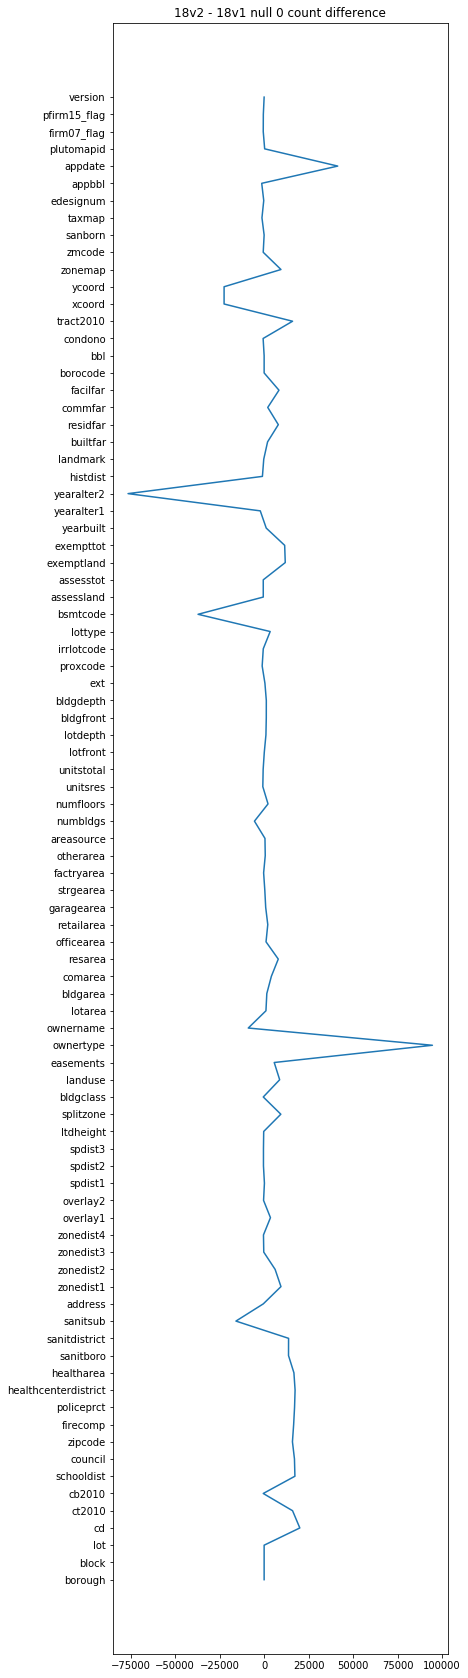

In [14]:
plt.figure(figsize=(6, 30))
plt.plot(null_all.iloc[1, :]-null_all.iloc[0, :], range(87))
plt.yticks(range(87), null_all.columns, rotation='horizontal')
plt.title('18v2 - 18v1 null 0 count difference')
plt.show()